In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBRegressor
import matplotlib.pyplot as plt

### Importing data

In [37]:
fat_df = pd.read_csv('data/data_clean/fat_data_clean.csv')
kcal_df = pd.read_csv('data/data_clean/kcal_data_clean.csv')
kg_df = pd.read_csv('data/data_clean/kg_data_clean.csv')
protein_df = pd.read_csv('data/data_clean/protein_data_clean.csv')

## Identifying Multicollinearity in Data

In [64]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [65]:
# Using fat_df just as preliminary dataset to identify multicollinearity
fat_df = fat_df.drop(['Country'], axis=1)

X = fat_df.iloc[:, :-6]
X_col = X.copy()
X = MinMaxScaler().fit_transform(X)
y = fat_df['Deaths']


vif_data = pd.DataFrame()
vif_data["feature"] = X_col.columns

In [66]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

# Initial results
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X, i)
                          for i in range(len(X_col.columns))]

In [67]:
#Identified that:
# - Vegetable Oil is highly correlative with Vegetable Products attribute
# - Milk and Animal Fats might correlate and fit with Animal Products
vif_data.sort_values('VIF')

,feature,VIF
18,Sugar & Sweeteners_f,1.894525e+00
3,"Aquatic Products, Other_f",3.423765e+00
0,Alcoholic Beverages_f,3.743534e+00
23,Obesity,8.263887e+00
17,Sugar Crops_f,1.079844e+01
9,Miscellaneous_f,1.321336e+02
11,Offals_f,1.421459e+03
22,Vegetables_f,2.050995e+03
15,Starchy Roots_f,3.085332e+03
13,Pulses_f,3.408131e+03


## Using XGBoost for Feature Importance

### Using Food Supply in Kcal dataset

In [38]:
# # Removing Country column due to it being categorical and not providing much information
# kcal_df = kcal_df[['Vegetal Products_kcal', 'Fish, Seafood_kcal', 'Spices_kcal', 
#                    'Offals_kcal', 'Vegetables_kcal','Animal Products_kcal',
#                    'Alcoholic Beverages_kcal','Sugar & Sweeteners_kcal','Confirmed','Deaths', 'Recovered'] Undernourished

kcal_df = kcal_df.drop(['Country', 'Obesity', 'Undernourished', 'Active', 'Population'], axis=1)
# kcal_df.describe()

##### Feature Importance for Confirmed Attribute

In [39]:
# Dividing the data between X and y of interest
X = kcal_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
X_col = X.copy()
# X = MinMaxScaler().fit_transform(X)
y = kcal_df['Confirmed'] 

In [40]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.434764145400858 (1.200054539639999)
RMSE: 1.8217588064905563 (0.3405275266038888)
MAE: 1.2725118642612578 (0.23672828837770502)
R2: 0.32310519619082617



Feature Importances:
    0.0098 - Alcoholic Beverages_kcal
    0.0226 - Animal Products_kcal
    0.0205 - Animal fats_kcal
    0.0000 - Aquatic Products, Other_kcal
    0.0217 - Cereals - Excluding Beer_kcal
    0.2901 - Eggs_kcal
    0.0544 - Fish, Seafood_kcal
    0.0107 - Fruits - Excluding Wine_kcal
    0.0088 - Meat_kcal
    0.2422 - Milk - Excluding Butter_kcal
    0.0523 - Miscellaneous_kcal
    0.0266 - Offals_kcal
    0.0293 - Oilcrops_kcal
    0.0145 - Pulses_kcal
    0.0084 - Spices_kcal
    0.0311 - Starchy Roots_kcal
    0.0472 - Stimulants_kcal
    0.0000 - Sugar Crops_kcal
    0.0201 - Sugar & Sweeteners_kcal
    0.0610 - Treenuts_kcal
    0.0000 - Vegetal Products_kcal
    0.0169 - Vegetable Oils_kcal
    0.0120 - Vegetables_kcal


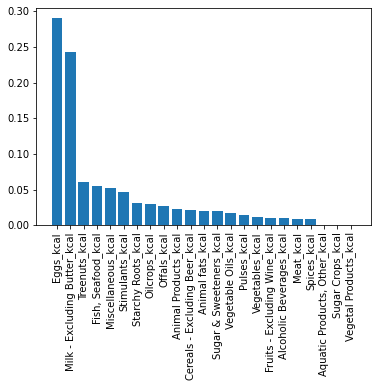

In [41]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [42]:
# Dividing the data between X and y of interest
X = kcal_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = kcal_df.iloc[:, :-6]
X_col = X.copy()

# Scaled data values by a scale of 100 so XGBoost can learn effectively (issues with small data values)
# Did this since we are only using model for feature importance (would not do for prediction model)
y = kcal_df['Deaths']

In [43]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 0.0018068240370452931 (0.0007727908742320586)
RMSE: 0.041548714487785396 (0.008973759605526857)
MAE: 0.02993852459189633 (0.006075296370111906)
R2: 0.2323495045121776



Feature Importances:
    0.0695 - Alcoholic Beverages_kcal
    0.0897 - Animal Products_kcal
    0.1257 - Animal fats_kcal
    0.0000 - Aquatic Products, Other_kcal
    0.0036 - Cereals - Excluding Beer_kcal
    0.1119 - Eggs_kcal
    0.0448 - Fish, Seafood_kcal
    0.0271 - Fruits - Excluding Wine_kcal
    0.0498 - Meat_kcal
    0.0328 - Milk - Excluding Butter_kcal
    0.0322 - Miscellaneous_kcal
    0.0315 - Offals_kcal
    0.1181 - Oilcrops_kcal
    0.0365 - Pulses_kcal
    0.0159 - Spices_kcal
    0.0389 - Starchy Roots_kcal
    0.0299 - Stimulants_kcal
    0.0000 - Sugar Crops_kcal
    0.0537 - Sugar & Sweeteners_kcal
    0.0183 - Treenuts_kcal
    0.0000 - Vegetal Products_kcal
    0.0554 - Vegetable Oils_kcal
    0.0147 - Vegetables_kcal


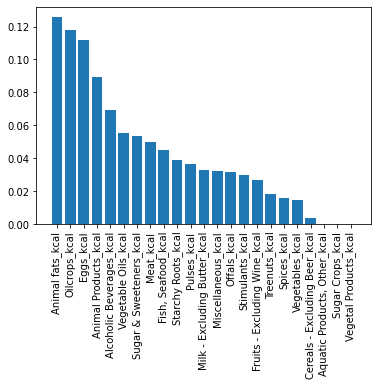

In [44]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [45]:
# Dividing the data between X and y of interest
X = kcal_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = kcal_df.iloc[:, :-6]
X_col = X.copy()
# X = MinMaxScaler().fit_transform(X)
y = kcal_df['Recovered']
y.describe()

count    164.000000
mean       1.452356
std        1.927617
min        0.000000
25%        0.099107
50%        0.475402
75%        2.622874
max        9.039871
Name: Recovered, dtype: float64

In [46]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.153151638148441 (1.450690244079238)
RMSE: 1.7292810763916315 (0.40340872199574657)
MAE: 1.1404034670828977 (0.2397335437349407)
R2: 0.0749886132415104



Feature Importances:
    0.0138 - Alcoholic Beverages_kcal
    0.0110 - Animal Products_kcal
    0.1066 - Animal fats_kcal
    0.0001 - Aquatic Products, Other_kcal
    0.0426 - Cereals - Excluding Beer_kcal
    0.3130 - Eggs_kcal
    0.0672 - Fish, Seafood_kcal
    0.0332 - Fruits - Excluding Wine_kcal
    0.0081 - Meat_kcal
    0.0828 - Milk - Excluding Butter_kcal
    0.0236 - Miscellaneous_kcal
    0.0442 - Offals_kcal
    0.0320 - Oilcrops_kcal
    0.0136 - Pulses_kcal
    0.0172 - Spices_kcal
    0.0324 - Starchy Roots_kcal
    0.0911 - Stimulants_kcal
    0.0000 - Sugar Crops_kcal
    0.0123 - Sugar & Sweeteners_kcal
    0.0493 - Treenuts_kcal
    0.0000 - Vegetal Products_kcal
    0.0038 - Vegetable Oils_kcal
    0.0020 - Vegetables_kcal


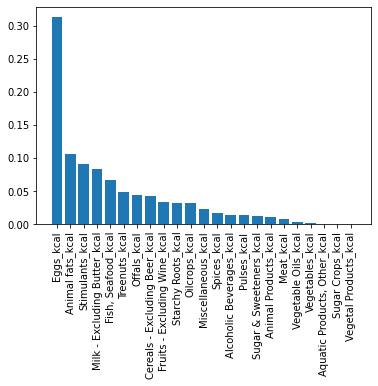

In [47]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

### Using Food Supply in Kg dataset

In [48]:
# # Removing Country column due to it being categorical and not providing much information
kg_df = kg_df.drop(['Country', 'Obesity', 'Undernourished', 'Active', 'Population'], axis=1)
#[['Vegetal Products_kg', 'Fish, Seafood_kg', 'Spices_kg', 
#                    'Offals_kg', 'Vegetables_kg','Animal Products_kg',
#                    'Alcoholic Beverages_kg','Sugar & Sweeteners_kg','Confirmed','Deaths', 'Recovered']]
# kg_df

##### Feature Importance for Confirmed Attribute

In [49]:
# Dividing the data between X and y of interest
X = kg_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# kg_df.iloc[:, :-6]
X_col = X.copy()
y = kg_df['Confirmed'] 

In [50]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.7821799535494227 (1.0477367686904995)
RMSE: 1.9242022263796315 (0.2821803422371783)
MAE: 1.374154338824132 (0.2134425715806917)
R2: 0.25952690282388946



Feature Importances:
    0.0290 - Alcoholic Beverages_kg
    0.0117 - Animal fats_kg
    0.2833 - Animal Products_kg
    0.0029 - Aquatic Products, Other_kg
    0.0415 - Cereals - Excluding Beer_kg
    0.1054 - Eggs_kg
    0.0428 - Fish, Seafood_kg
    0.0026 - Fruits - Excluding Wine_kg
    0.0241 - Meat_kg
    0.1696 - Milk - Excluding Butter_kg
    0.0127 - Miscellaneous_kg
    0.0110 - Offals_kg
    0.0267 - Oilcrops_kg
    0.0158 - Pulses_kg
    0.0284 - Spices_kg
    0.0120 - Starchy Roots_kg
    0.0532 - Stimulants_kg
    0.0054 - Sugar & Sweeteners_kg
    0.0009 - Sugar Crops_kg
    0.0395 - Treenuts_kg
    0.0273 - Vegetable Oils_kg
    0.0539 - Vegetables_kg
    0.0000 - Vegetal Products_kg


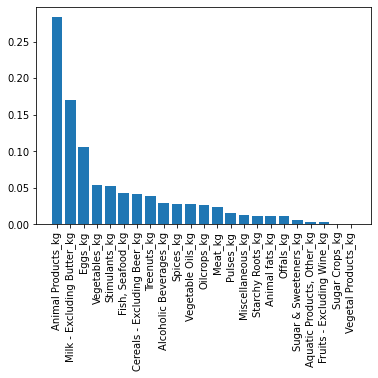

In [51]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [52]:
# Dividing the data between X and y of interest
X = kg_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# kg_df.iloc[:, :-6]
X_col = X.copy()
y = kg_df['Deaths']

In [53]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 0.001854266111212717 (0.0011069856403111283)
RMSE: 0.04152135595069584 (0.011412410403956406)
MAE: 0.030648431068948 (0.007991470882859966)
R2: 0.17673298069321944



Feature Importances:
    0.0547 - Alcoholic Beverages_kg
    0.0292 - Animal fats_kg
    0.0995 - Animal Products_kg
    0.0113 - Aquatic Products, Other_kg
    0.0074 - Cereals - Excluding Beer_kg
    0.1304 - Eggs_kg
    0.0696 - Fish, Seafood_kg
    0.0429 - Fruits - Excluding Wine_kg
    0.0520 - Meat_kg
    0.0962 - Milk - Excluding Butter_kg
    0.0116 - Miscellaneous_kg
    0.0103 - Offals_kg
    0.1110 - Oilcrops_kg
    0.0496 - Pulses_kg
    0.0072 - Spices_kg
    0.0024 - Starchy Roots_kg
    0.0434 - Stimulants_kg
    0.0424 - Sugar & Sweeteners_kg
    0.0148 - Sugar Crops_kg
    0.0351 - Treenuts_kg
    0.0195 - Vegetable Oils_kg
    0.0596 - Vegetables_kg
    0.0000 - Vegetal Products_kg


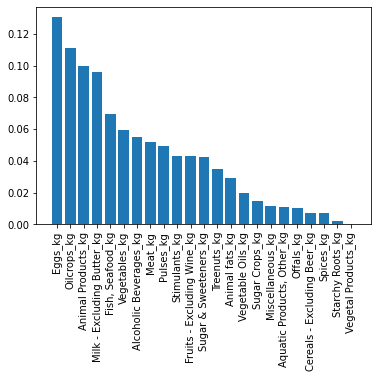

In [54]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [55]:
# Dividing the data between X and y of interest
X = kg_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# kg_df.iloc[:, :-6]
X_col = X.copy()
y = kg_df['Recovered']

In [56]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.271726691542206 (1.2077540227681203)
RMSE: 1.7775006409895895 (0.3349897951039774)
MAE: 1.2928536205976222 (0.2339646122361749)
R2: 0.0025399002148706385



Feature Importances:
    0.0285 - Alcoholic Beverages_kg
    0.0375 - Animal fats_kg
    0.0307 - Animal Products_kg
    0.0320 - Aquatic Products, Other_kg
    0.0186 - Cereals - Excluding Beer_kg
    0.1656 - Eggs_kg
    0.0765 - Fish, Seafood_kg
    0.0245 - Fruits - Excluding Wine_kg
    0.0221 - Meat_kg
    0.0267 - Milk - Excluding Butter_kg
    0.0166 - Miscellaneous_kg
    0.0321 - Offals_kg
    0.1235 - Oilcrops_kg
    0.0307 - Pulses_kg
    0.0068 - Spices_kg
    0.1230 - Starchy Roots_kg
    0.0132 - Stimulants_kg
    0.0521 - Sugar & Sweeteners_kg
    0.0795 - Sugar Crops_kg
    0.0049 - Treenuts_kg
    0.0125 - Vegetable Oils_kg
    0.0424 - Vegetables_kg
    0.0000 - Vegetal Products_kg


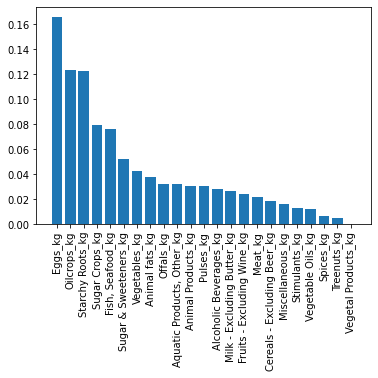

In [57]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

### Using Protein Supply dataset

In [58]:
# # Removing Country column due to it being categorical and not providing much information
protein_df = protein_df.drop(['Country', 'Obesity', 'Undernourished', 'Active', 'Population'], axis=1)
#[['Vegetal Products_p', 'Fish, Seafood_p', 'Spices_p', 
#                    'Offals_p', 'Vegetables_p','Animal Products_p',
#                    'Alcoholic Beverages_p','Sugar & Sweeteners_p','Confirmed','Deaths', 'Recovered']]
# protein_df

##### Feature Importance for Confirmed Attribute

In [59]:
# Dividing the data between X and y of interest
X = protein_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
X_col = X.copy()
y = protein_df['Confirmed'] 

In [60]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.431943504999679 (2.1286794601062606)
RMSE: 1.7577055512789734 (0.5851621142920651)
MAE: 1.2376353126969033 (0.4075450777510045)
R2: 0.3742040950790796



Feature Importances:
    0.0108 - Alcoholic Beverages_p
    0.0179 - Animal Products_p
    0.0216 - Animal fats_p
    0.0242 - Aquatic Products, Other_p
    0.0132 - Cereals - Excluding Beer_p
    0.0316 - Eggs_p
    0.0100 - Fish, Seafood_p
    0.0079 - Fruits - Excluding Wine_p
    0.0442 - Meat_p
    0.3101 - Milk - Excluding Butter_p
    0.0094 - Offals_p
    0.0326 - Oilcrops_p
    0.0328 - Pulses_p
    0.0095 - Spices_p
    0.0098 - Starchy Roots_p
    0.0241 - Stimulants_p
    0.0052 - Sugar Crops_p
    0.3242 - Sugar & Sweeteners_p
    0.0131 - Treenuts_p
    0.0000 - Vegetal Products_p
    0.0081 - Vegetable Oils_p
    0.0175 - Vegetables_p
    0.0222 - Miscellaneous_p


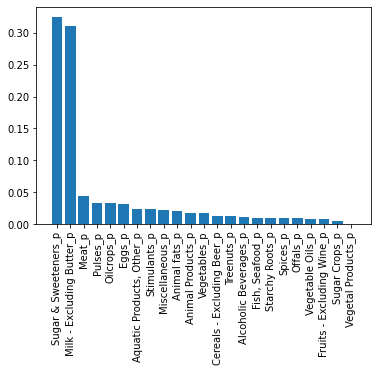

In [61]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [62]:
# Dividing the data between X and y of interest
X = protein_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
X_col = X.copy()
y = protein_df['Deaths']

In [63]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 0.0018693071457358632 (0.000915097985173205)
RMSE: 0.04209263140800268 (0.00987509629755021)
MAE: 0.030458822354401095 (0.007302186191040915)
R2: 0.16669417715774265



Feature Importances:
    0.0191 - Alcoholic Beverages_p
    0.0115 - Animal Products_p
    0.0952 - Animal fats_p
    0.0198 - Aquatic Products, Other_p
    0.0400 - Cereals - Excluding Beer_p
    0.1039 - Eggs_p
    0.0368 - Fish, Seafood_p
    0.0104 - Fruits - Excluding Wine_p
    0.0410 - Meat_p
    0.0882 - Milk - Excluding Butter_p
    0.0140 - Offals_p
    0.0099 - Oilcrops_p
    0.0250 - Pulses_p
    0.0630 - Spices_p
    0.0248 - Starchy Roots_p
    0.0183 - Stimulants_p
    0.0000 - Sugar Crops_p
    0.0841 - Sugar & Sweeteners_p
    0.0182 - Treenuts_p
    0.0001 - Vegetal Products_p
    0.1988 - Vegetable Oils_p
    0.0492 - Vegetables_p
    0.0287 - Miscellaneous_p


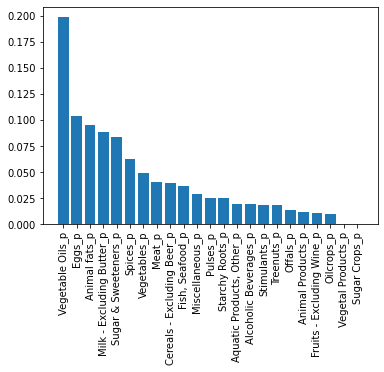

In [64]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [65]:
# Dividing the data between X and y of interest
X = protein_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
X_col = X.copy()
y = protein_df['Recovered']

In [66]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.4464314302830226 (1.442168919910904)
RMSE: 1.8089382064440351 (0.41734158138155886)
MAE: 1.2451876003900673 (0.26119295808397863)
R2: -0.09865398031695985



Feature Importances:
    0.0043 - Alcoholic Beverages_p
    0.0124 - Animal Products_p
    0.0119 - Animal fats_p
    0.0222 - Aquatic Products, Other_p
    0.0153 - Cereals - Excluding Beer_p
    0.2080 - Eggs_p
    0.0357 - Fish, Seafood_p
    0.0163 - Fruits - Excluding Wine_p
    0.0527 - Meat_p
    0.0660 - Milk - Excluding Butter_p
    0.0605 - Offals_p
    0.1079 - Oilcrops_p
    0.0103 - Pulses_p
    0.0306 - Spices_p
    0.0363 - Starchy Roots_p
    0.1277 - Stimulants_p
    0.0085 - Sugar Crops_p
    0.0231 - Sugar & Sweeteners_p
    0.0650 - Treenuts_p
    0.0000 - Vegetal Products_p
    0.0560 - Vegetable Oils_p
    0.0206 - Vegetables_p
    0.0086 - Miscellaneous_p


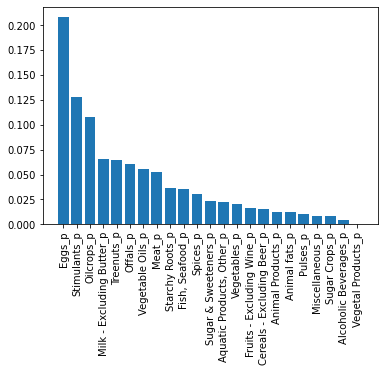

In [67]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

### Using Fat Supply dataset

In [68]:
# # Removing Country column due to it being categorical and not providing much information
fat_df = fat_df.drop(['Country', 'Obesity', 'Undernourished', 'Active', 'Population'], axis=1)
#[['Vegetal Products_p', 'Fish, Seafood_p', 'Spices_p', 
#                    'Offals_p', 'Vegetables_p','Animal Products_p',
#                    'Alcoholic Beverages_p','Sugar & Sweeteners_p','Confirmed','Deaths', 'Recovered']]
fat_df

,Alcoholic Beverages_f,Animal Products_f,Animal fats_f,"Aquatic Products, Other_f",Cereals - Excluding Beer_f,Eggs_f,"Fish, Seafood_f",Fruits - Excluding Wine_f,Meat_f,Miscellaneous_f,...,Stimulants_f,Sugar Crops_f,Sugar & Sweeteners_f,Treenuts_f,Vegetal Products_f,Vegetable Oils_f,Vegetables_f,Confirmed,Deaths,Recovered
0,0.0000,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,0.0163,...,0.0980,0.0000,0.0,0.7513,28.3684,17.0831,0.3593,0.142134,0.006186,0.123374
1,0.0000,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,0.0170,...,0.5270,0.0000,0.0,0.9181,17.9998,9.2443,0.6503,2.967301,0.050951,1.792636
2,0.0000,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,0.0439,...,0.2886,0.0000,0.0,0.8595,35.5857,27.3606,0.5145,0.244897,0.006558,0.167572
3,0.0000,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,0.0308,...,0.1128,0.0000,0.0,0.0308,34.7010,22.4638,0.1231,0.061687,0.001461,0.056808
4,0.0000,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,0.0898,...,1.0549,0.0000,0.0,0.2020,22.2995,14.4436,0.2469,0.293878,0.007143,0.190816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.0000,16.3261,2.2673,0.0,2.5449,0.6555,0.5707,0.9640,7.0949,0.0077,...,0.0848,0.0000,0.0,0.0154,33.6855,29.5211,0.1851,0.452585,0.004287,0.424399
160,0.0000,33.2484,3.8238,0.0,3.7155,0.7839,1.1217,0.4079,26.4292,0.0064,...,0.0829,0.0382,0.0,1.1726,16.7548,5.6211,0.6373,0.002063,0.000036,0.001526
161,0.0000,12.5401,2.0131,0.0,11.5271,0.5514,0.3847,0.2564,8.0010,0.0256,...,0.3718,0.0000,0.0,0.0769,37.4535,23.6312,0.1667,0.007131,0.002062,0.004788
162,0.0783,9.6005,1.6113,0.0,14.3225,0.6266,1.0070,0.1343,4.9010,0.0224,...,0.0671,0.0000,0.0,0.0112,40.3939,15.2848,0.1567,0.334133,0.004564,0.290524


##### Feature Importance for Confirmed Attribute

In [69]:
# Dividing the data between X and y of interest
X = fat_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
X_col = X.copy()
y = fat_df['Confirmed'] 

In [70]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 4.297919245394085 (2.117846893186742)
RMSE: 2.0097625279998423 (0.508698168309821)
MAE: 1.3784524259743507 (0.3654462098972007)
R2: 0.18757470569529255



Feature Importances:
    0.0001 - Alcoholic Beverages_f
    0.0070 - Animal Products_f
    0.0276 - Animal fats_f
    0.0017 - Aquatic Products, Other_f
    0.0265 - Cereals - Excluding Beer_f
    0.3510 - Eggs_f
    0.0878 - Fish, Seafood_f
    0.0077 - Fruits - Excluding Wine_f
    0.0048 - Meat_f
    0.0123 - Miscellaneous_f
    0.1603 - Milk - Excluding Butter_f
    0.0081 - Offals_f
    0.0217 - Oilcrops_f
    0.0846 - Pulses_f
    0.0334 - Spices_f
    0.0710 - Starchy Roots_f
    0.0544 - Stimulants_f
    0.0004 - Sugar Crops_f
    0.0000 - Sugar & Sweeteners_f
    0.0275 - Treenuts_f
    0.0000 - Vegetal Products_f
    0.0006 - Vegetable Oils_f
    0.0115 - Vegetables_f


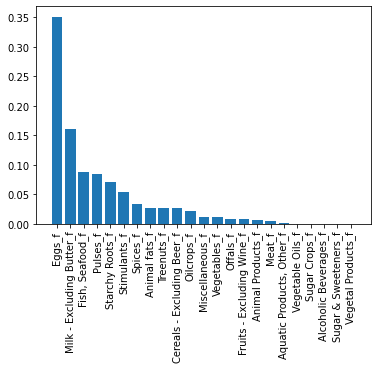

In [71]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [72]:
# Dividing the data between X and y of interest
X = fat_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
X_col = X.copy()
y = fat_df['Deaths']

In [73]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 0.0018234742647525379 (0.0008286675666118098)
RMSE: 0.04158841663216097 (0.009689059127817055)
MAE: 0.03067166249149327 (0.0057181258544259615)
R2: 0.2287766089714051



Feature Importances:
    0.0001 - Alcoholic Beverages_f
    0.0168 - Animal Products_f
    0.0556 - Animal fats_f
    0.0000 - Aquatic Products, Other_f
    0.1057 - Cereals - Excluding Beer_f
    0.1348 - Eggs_f
    0.0381 - Fish, Seafood_f
    0.0385 - Fruits - Excluding Wine_f
    0.0133 - Meat_f
    0.0594 - Miscellaneous_f
    0.1698 - Milk - Excluding Butter_f
    0.0360 - Offals_f
    0.1004 - Oilcrops_f
    0.0345 - Pulses_f
    0.0316 - Spices_f
    0.0335 - Starchy Roots_f
    0.0845 - Stimulants_f
    0.0005 - Sugar Crops_f
    0.0004 - Sugar & Sweeteners_f
    0.0217 - Treenuts_f
    0.0000 - Vegetal Products_f
    0.0027 - Vegetable Oils_f
    0.0220 - Vegetables_f


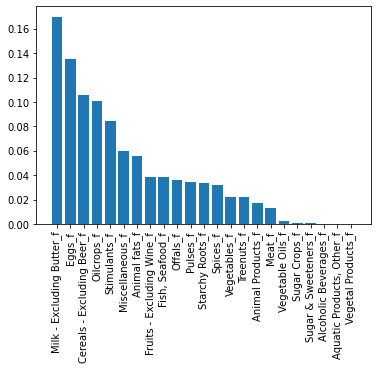

In [74]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [75]:
# Dividing the data between X and y of interest
X = fat_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
X_col = X.copy()
y = fat_df['Recovered']

In [76]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
# params = {'gamma': [0.5, 1, 1.5, 2, 5],
#           'max_depth': [3, 4, 5], 
#           'min_child_weight': [1, 2, 5, 10]
#          }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
# xgb_gs = GridSearchCV(xgb, param_grid=params)
# xgb_gs.fit(X, y)
xgb.fit(X,y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")
print(f"R2: {r2.mean()}")

MSE: 3.3962358569514253 (2.3408186648322666)
RMSE: 1.751521887307354 (0.5730680022778354)
MAE: 1.213775760159893 (0.3378879375732844)
R2: 0.07063085278880199



Feature Importances:
    0.0004 - Alcoholic Beverages_f
    0.0068 - Animal Products_f
    0.0838 - Animal fats_f
    0.0000 - Aquatic Products, Other_f
    0.0129 - Cereals - Excluding Beer_f
    0.2088 - Eggs_f
    0.0444 - Fish, Seafood_f
    0.0423 - Fruits - Excluding Wine_f
    0.0080 - Meat_f
    0.0073 - Miscellaneous_f
    0.0834 - Milk - Excluding Butter_f
    0.0282 - Offals_f
    0.0587 - Oilcrops_f
    0.0223 - Pulses_f
    0.0086 - Spices_f
    0.0417 - Starchy Roots_f
    0.2660 - Stimulants_f
    0.0000 - Sugar Crops_f
    0.0007 - Sugar & Sweeteners_f
    0.0411 - Treenuts_f
    0.0000 - Vegetal Products_f
    0.0156 - Vegetable Oils_f
    0.0189 - Vegetables_f


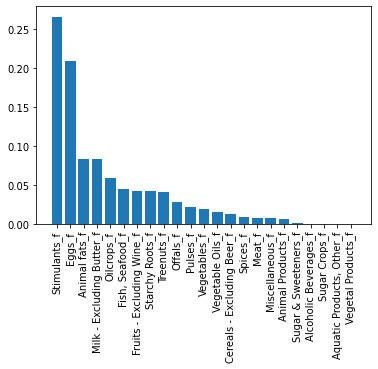

In [77]:
# Get Feature Importance from model
importance = xgb.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()